In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import pulse2percept.utils as p2pu

import skimage.io as skio
import skimage.transform as skit

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-14 17:08:03,232 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
results_dir = '../../results/shape9cv/'
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([0.5, 1.5, 1.0, 0.6], index=subjectdata.index)
subjectdata

,implant_rot,implant_x,implant_y,loc_od_x,loc_od_y,second_sight_id,xrange,yrange,implant_type,scale
subject_id,,,,,,,,,,
S4,-0.457,-1230,415,15.9,1.96,52-001,"(-32.0, 32.0)","(-24.0, 24.0)",<class 'pulse2percept.implants.ArgusII'>,0.5
S3,-1.090,-799,93,15.7,0.75,51-009,"(-32.5, 32.5)","(-24.4, 24.4)",<class 'pulse2percept.implants.ArgusII'>,1.5
S1,-1.130,-1527,-556,13.6,0.00,TB,"(-36.9, 36.9)","(-36.9, 36.9)",<class 'pulse2percept.implants.ArgusI'>,1.0
S2,-0.188,-1761,-212,15.4,1.86,12-005,"(-30.0, 30.0)","(-22.5, 22.5)",<class 'pulse2percept.implants.ArgusII'>,0.6


In [3]:
# subjectdata.index = ['52-001', '51-009', '12-005', 'TB']

In [4]:
subjects = subjectdata.index.sort_values()

In [5]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [6]:
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 431 files


In [7]:
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [8]:
data = load_data(pickle_files, verbose=False)

In [9]:
data = data[data.model == 'C2']

In [10]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [11]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']

In [12]:
data.groupby(groupcols + ['idx_fold'], sort=False)['exetime'].agg(['count', 'mean', 'std'])

count          mean           std
subject model idx_fold                                   
S1      C2    0            10   7813.104228   3623.879829
              1            10   8204.785379   2845.235926
              2            10  11236.149594  10205.631447
              3            10  10029.163751  10692.755856
              4             8   7734.821331   3472.909621
              5             8  13032.616469  11078.775756
              6             6   8683.469771   3658.478153
              7             6   7700.260567   2395.724993
              8             6   6189.743029   2535.514189
              9             6   9066.613726   5372.059032
S2      C2    0             5  81034.182631  37226.733378
              1             4  30865.104060  22663.592587
              2             2  37924.124384  30945.442390
              3             1  17775.840953           NaN
S3      C2    0             4  24270.997162  16533.277934
              1             4  31786.482771  38945.942714
              2             4  41299.409147  32220.393775
              3             4  24806.853882   5706.287478
              4             2  27077.138555   4585.994781
              5             2  15731.388363   6097.141515
              6             2  18174.231741   2695.236015
              7             1  23201.284113           NaN
S4      C2    0             5  60351.182078  17952.398383
              1             5  48165.215388  32882.333149
              2             4  41313.567168   5241.183682
              3             2  53343.974021   6103.400761

In [13]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

rho                 axlambda               \
                              mean         std         mean          std   
subject model idx_fold                                                     
S1      C2    0         778.193017  156.272581  1382.130081   909.876906   
              1         725.488366  162.587933  1026.188684   973.593667   
              2         462.066342  237.819972  1509.167869   814.278600   
              3         614.451557  217.261437  1156.452598   767.795872   
              4         480.947013  234.210780  1428.098674   711.288208   
              5         428.490261  216.575632  1809.561208   729.536239   
              6         785.594849   30.022186   604.201921   123.960076   
              7         726.713232  193.100726  1319.886342  1168.610930   
              8         806.004891   79.583773  1530.441841  1065.704431   
              9         827.303444  373.817558  1376.639578   851.061905   
S2      C2    0         441.680407   56.401811  1704.660232  1027.149243   
              1         440.218943   27.940933  2269.289298   505.455401   
              2         456.478806   23.566107  2510.185206   691.861070   
              3         522.562790         NaN  2080.419330          NaN   
S3      C2    0          70.368675   14.364482  1492.711409   828.836009   
              1          74.957287   19.047911  1466.007142  1022.755388   
              2          78.844828    8.479993  2269.130577   781.083233   
              3          80.802726    5.435057  1476.522293   827.506737   
              4          83.662979    0.511491  1036.861453    12.892805   
              5         101.074937   23.418283  1978.020967  1445.296609   
              6          76.860662    9.397989  1850.994192  1141.937464   
              7          82.156894         NaN  2983.033382          NaN   
S4      C2    0         653.833227   84.003334  2165.082314   642.044483   
              1         564.608684   82.268370  1571.113156   922.822442   
              2         517.003348   19.836653  1373.203564   757.762999   
              3         602.825460  127.346455  2831.682222    82.552213   

                       best_train_cost                       
                                 count       mean       std  
subject model idx_fold                                       
S1      C2    0                     10   4.539404  0.326991  
              1                     10   4.502937  0.553416  
              2                     10   4.792919  0.114499  
              3                     10   4.889769  0.413480  
              4                      8   4.990919  0.189246  
              5                      8   5.029412  0.192742  
              6                      6   3.918021  0.102421  
              7                      6   4.593859  0.563087  
              8                      6   5.072620  0.197016  
              9                      6   5.183309  0.869701  
S2      C2    0                      5  11.031834  0.640628  
              1                      4  11.752424  0.258801  
              2                      2  11.972724  0.288747  
              3                      1  12.290523       NaN  
S3      C2    0                      4   7.884396  1.783174  
              1                      4   8.887709  1.010555  
              2                      4   8.174918  0.168661  
              3                      4   8.434727  0.157600  
              4                      2   8.081560  0.001974  
              5                      2   9.370601  1.409238  
              6                      2   8.630178  0.455812  
              7                      1   8.528757       NaN  
S4      C2    0                      5  10.833882  0.325069  
              1                      5  10.844111  0.646167  
              2                      4  10.192036  0.735824  
              3                      2  10.124992  0.284392

# The best runs in their respective category

In [14]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


rho     axlambda best_train_cost           
                              mean         mean           count        min
subject model idx_fold                                                    
S1      C2    0         775.796267   520.935209               1   4.163641
              1         766.961971   524.967354               1   4.229272
              2         838.759867   513.358296               1   4.662875
              3         775.607512   551.370730               1   4.547841
              4         768.352327   603.325779               1   4.748626
              5         820.089921   569.742315               1   4.668232
              6         775.844946   520.515530               1   3.792418
              7         820.726963   555.605881               1   4.185176
              8         792.988663   561.329428               1   4.784960
              9         767.477403   665.874152               1   4.443304
S2      C2    0         533.701471    70.235151               1   9.991220
              1         440.409893  2681.657899               1  11.389342
              2         439.815052  2999.404860               1  11.768549
              3         522.562790  2080.419330               1  12.290523
S3      C2    0          83.607167  1409.985236               1   6.859812
              1          85.320489   945.022165               1   7.981637
              2          91.318003  1122.263040               1   7.955163
              3          83.532389  1025.875592               1   8.327715
              4          84.024658  1027.744863               1   8.080163
              5          84.515710   956.041935               1   8.374120
              6          83.506044  1043.522467               1   8.307871
              7          82.156894  2983.033382               1   8.528757
S4      C2    0         503.870588  1093.119562               1  10.253016
              1         566.177017   399.185133               1   9.999387
              2         542.640854   426.804818               1   9.530261
              3         512.777918  2890.055452               1   9.923896

In [15]:
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols)
gb.agg({'rho': ['mean', 'std'], 'axlambda': ['mean', 'std']})

rho                axlambda             
                     mean        std         mean          std
subject model                                                 
S1      C2     790.260584  26.564853   558.702468    46.842398
S2      C2     484.122301  51.021800  1957.929310  1314.895108
S3      C2      84.747669   2.805743  1314.186085   690.138989
S4      C2     531.366594  28.521592  1202.291241  1170.017820

In [16]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        best_loss = 0
        angles = []
        dices = []
        for yt, yp in zip(data['y_test'], data['y_pred']):
            loss, angle, dice = argus_shapes.imgproc.rd_loss(yt['image'].values[0], 
                                                             yp['image'].values[0], 
                                                             return_all=True)
            best_loss += loss
            angles.append(angle)
            dices.append(dice)
        compact_row = {
            'subject': subject,
            'model': model,
            'best_test_cost': best_loss,
            'angle': pd.DataFrame(angles, index=data.index),
            'dice': pd.DataFrame(dices, index=data.index),
        }
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [17]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,angle,best_test_cost,dice,model,subject
0,0 5 5.0 11 70.0 27 35.0 31 3...,5.084661,0 5 0.330508 11 0.652981 27 0.8...,C2,S1
1,0 134 -125.0 135 -45.0 139 10.0 14...,3.156942,0 134 0.671906 135 0.677224 139 ...,C2,S2
2,0 234 175.0 237 -5.0 242 -20.0 24...,6.561650,0 234 0.000000 237 0.367347 242 ...,C2,S3
3,0 320 -15.0 325 -155.0 331 -170.0 33...,4.088168,0 320 0.570799 325 0.696096 331 ...,C2,S4


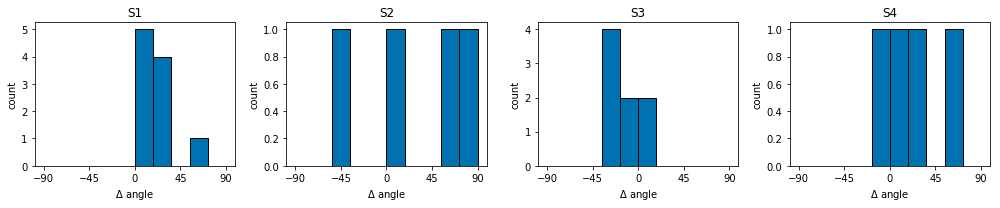

In [18]:
fig, axes = plt.subplots(ncols=len(best), figsize=(14, 3))
for (_, row), ax in zip(best.iterrows(), axes.ravel()):
    angles = row['angle']
    angles[angles < -90] += 180
    angles[angles > 90] -= 180
    ax.hist(angles, range=(-90, 90), bins=10, edgecolor='black')
    ax.set_xlabel('$\Delta$ angle')
    ax.set_ylabel('count')
    ax.set_xticks(np.linspace(-90, 90, 5))
    ax.set_title(row['subject'])
fig.tight_layout()
fig.savefig('hist-anglediff.png')

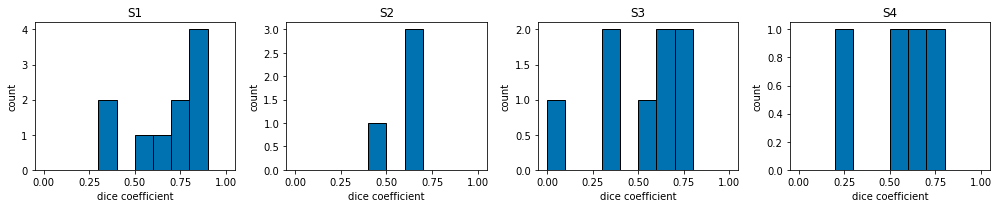

In [19]:
fig, axes = plt.subplots(ncols=len(best), figsize=(14, 3))
for (_, row), ax in zip(best.iterrows(), axes.ravel()):
    ax.hist(row['dice'], range=(0, 1), bins=10, edgecolor='black')
    ax.set_xlabel('dice coefficient')
    ax.set_ylabel('count')
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_title(row['subject'])
fig.tight_layout()
fig.savefig('hist-dice.png')

In [20]:
meow

NameError: name 'meow' is not defined

# Plot predictions

In [ ]:
plotmodel = 'A'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
limits = [[-8, 880], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.eps' % plotmodel)

In [ ]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
limits = [[-8, 880], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.eps' % plotmodel)

In [ ]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [ ]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])
px_argus1[:, 0] += 70
px_argus1[:, 1] -= 70

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [ ]:
def plot_phosphenes_on_array(ax, subject, Xymu, subjectdata):
    Xymu = Xymu[Xymu.subject == subject]
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        px_argus = px_argus2
        img_argus = img_argus2
    else:
        px_argus = px_argus1
        img_argus = img_argus1    
    
    padding = 2000
    x_range = (p2pr.ret2dva(np.min([e.x_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.x_center for e in argus]) + padding))
    y_range = (p2pr.ret2dva(np.min([e.y_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.y_center for e in argus]) + padding))
    out_shape = Xymu.img_shape.unique()[0]  # (np.diff(y_range)[0] * 10, np.diff(x_range)[0] * 10)
    pts_in = []
    pts_dva = []
    pts_out = []
    for xy, e in zip(px_argus, argus):
        pts_in.append(xy)
        dva = p2pr.ret2dva([e.x_center, e.y_center])
        pts_dva.append(dva)
        xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
        yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
        pts_out.append([xout, yout])
    argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
    dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
    argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))
    
    # top left, top right, bottom left, bottom right
    pts_draw = [[0, 0], [0, out_shape[1] - 1],
                [out_shape[0] - 1, 0], [out_shape[1] - 1, out_shape[0] - 1]]
    x_range = subjectdata.loc[subject, 'xrange']
    y_range = subjectdata.loc[subject, 'yrange']
    pts_dva = [[x_range[0], y_range[0]], [x_range[0], y_range[1]],
               [x_range[1], y_range[0]], [x_range[1], y_range[1]]]
    draw2dva = skit.estimate_transform('similarity', np.array(pts_draw), np.array(pts_dva))

    all_imgs = np.zeros(out_shape)
    for _, row in Xymu.iterrows():
        e_pos = p2pr.ret2dva((argus[row['electrode']].x_center, argus[row['electrode']].y_center))
        align_center = dva2out(e_pos)[0]
        img_drawing = argus_shapes.imgproc.scale_phosphene(row['image'], subjectdata.loc[subject, 'scale'])
        img_drawing = argus_shapes.imgproc.center_phosphene(img_drawing, center=align_center[::-1])
        all_imgs += img_drawing
    all_imgs = np.maximum(0, np.minimum(1, 1 - all_imgs))
    ax.imshow(np.ma.masked_where(all_imgs > 0.5, all_imgs), vmin=0, vmax=1, cmap='gray')
    ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
    
    fovea = fovea = dva2out([0, 0])[0]
    ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

In [ ]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3, figsize=(12, 4 * len(subjects)))
for subject, axrow in zip(subjects, axes):
    for model, col, ax in zip(['A', 'A', 'C'], ['y_test', 'y_pred', 'y_pred'], axrow):
        yp = best[np.logical_and(best['subject'] == subject, best['model'] == model)][col].values[0]
        yp['subject'] = pd.Series([subject for _, _ in yp.iterrows()], index=yp.index)
        plot_phosphenes_on_array(ax, subject, yp, subjectdata)
        ax.set_xticks([])
        ax.set_yticks([])
    axrow[0].set_ylabel(subject, fontsize=16)
fig.savefig('fig7-model-scatter.eps')